### 얼굴 전체 색소침착 카운트 파악 - EffientNet 회귀 모델 - 일반화 성능 실패
### 얼굴 미간 주름 등급 예측 - ResNet 분류 모델 - 성능 양호

## 1 데이터 파악 및 환경설정

In [1]:
# 라벨 파싱 함수(주름 클래스 추출, 예시)
import json
import os


def extract_data(json_path):
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
        gender = data['info']['gender']
        age = data['info']['age']
        skin_type = data['info']['skin_type']
        acne = data['annotations']['acne']
        pigmentation_count = data['equipment']['pigmentation_count']
        return gender, age, skin_type, acne, pigmentation_count

# 테스트 예시
label_path = r"D:\PyProject\datasets\skinAI\korea_skin_data\model_and_data\docker_image\skin_dataset\data_and_model\dataset\label\03\0001/0001_03_F_00.json"
gender, age, skin_type, acne, pigmentation_count = extract_data(label_path)
print(f"피부(색소)침착 개수: {pigmentation_count}")
print(f"성별: {gender}, 나이: {age}, 피부타입: {skin_type}, 여드름 유무: {acne}")

피부(색소)침착 개수: 147
성별: F, 나이: 55, 피부타입: 3, 여드름 유무: None


### 참고 이마 색소침착 등급파악

In [3]:
# 라벨 파싱 함수(주름 클래스 추출, 예시)
import json
import os

def extract_forehead_pigmentation_level(json_path):
    with open(json_path) as f:
        data = json.load(f)
        return data['annotations']['forehead_pigmentation']  # 0~9 값 반환

# 테스트 예시
label_path = r"D:\PyProject\datasets\skinAI\korea_skin_data\model_and_data\docker_image\skin_dataset\data_and_model\dataset\label\03\0001/0001_03_F_01.json"
forehead_pigmentation_level = extract_forehead_pigmentation_level(label_path)
print(f"이마 색소침착 등급: {forehead_pigmentation_level}")

이마 색소침착 등급: 1


# 색소침착 수 데이터 분포 파악

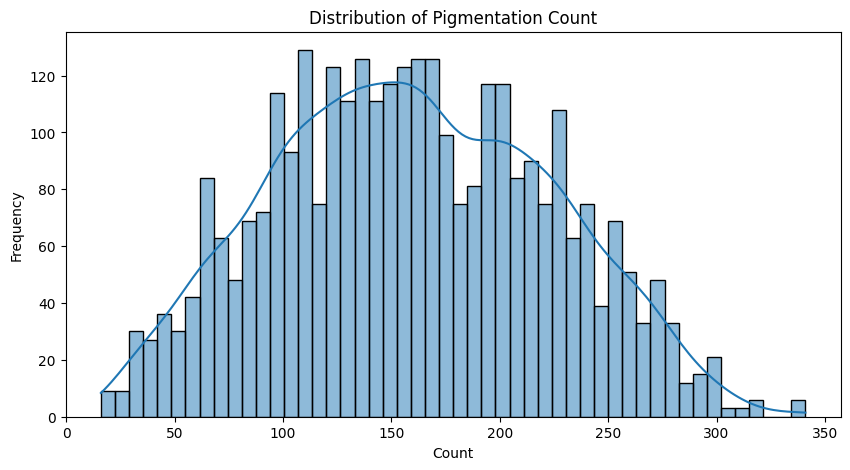

In [3]:
import seaborn as sns
import pandas as pd
import os

import json
from collections import defaultdict
import matplotlib.pyplot as plt

label_dir = r"D:\PyProject\datasets\skinAI\korea_skin_data\model_and_data\docker_image\skin_dataset\data_and_model\dataset\label\03"
# 데이터 수집
pigmentation_counts = []
for folder in range(1, 1101):
    folder_name = f"{folder:04d}"
    for angle in ['F', 'L', 'R']:
        json_path = f"{label_dir}/{folder_name}/{folder_name}_03_{angle}_00.json"
        if os.path.exists(json_path):
            with open(json_path) as f:
                data = json.load(f)
                pigmentation_counts.append(data['equipment']['pigmentation_count'])

# 분포 시각화
plt.figure(figsize=(10, 5))
sns.histplot(pigmentation_counts, bins=50, kde=True)
plt.title('Distribution of Pigmentation Count')
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.show()

class
0    204
1    555
2    810
3    756
4    588
5    261
6     42
Name: count, dtype: int64


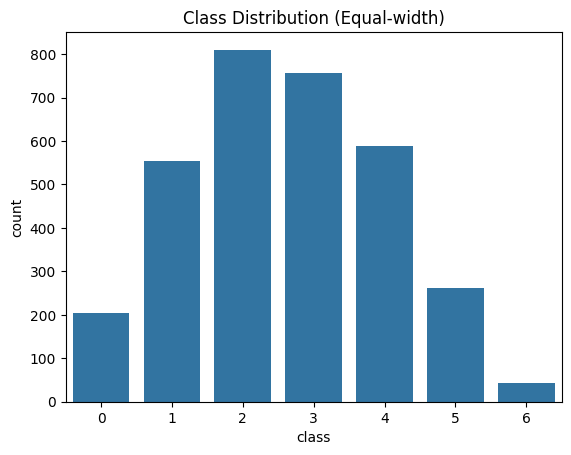

In [5]:
# (1) 균등 분포 (Equal-width binning)
import numpy as np

# numpy로 구간 설정
bins = np.linspace(min(pigmentation_counts), max(pigmentation_counts), 8)  # 7개 클래스면 구간은 8개 필요
labels = range(7)

# pandas로 클래스 라벨 할당
df = pd.DataFrame({'count': pigmentation_counts})
df['class'] = pd.cut(df['count'], bins=bins, labels=labels, include_lowest=True)

# 분포 확인
print(df['class'].value_counts().sort_index())
sns.countplot(x=df['class'])
plt.title('Class Distribution (Equal-width)')
plt.show()

class
0    462
1    468
2    456
3    474
4    441
5    474
6    441
Name: count, dtype: int64


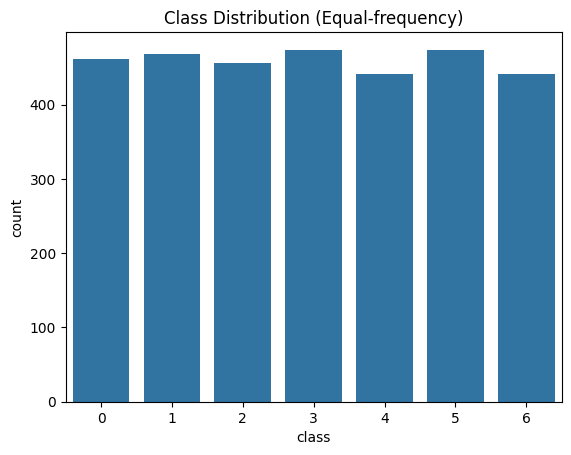

In [7]:
# (2) 균등 수량 (Equal-frequency binning)
# qcut으로 분할 (비슷한 개수로 나누기)
df = pd.DataFrame({'count': pigmentation_counts})
df['class'] = pd.qcut(df['count'], q=7, labels=False)

# 분포 확인
print(df['class'].value_counts().sort_index())
sns.countplot(x=df['class'])
plt.title('Class Distribution (Equal-frequency)')
plt.show()

final_class
1    759
2    810
3    756
4    588
5    303
Name: count, dtype: int64


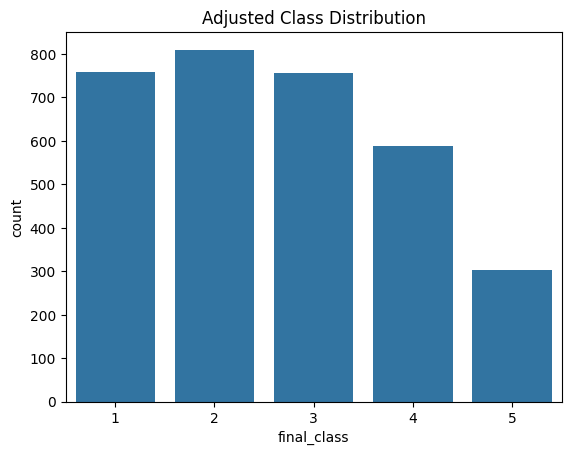

In [11]:
# 클래스 병합 및 재분류
df = pd.DataFrame({'count': pigmentation_counts})
df['cut_class'] = pd.cut(df['count'], bins=np.linspace(min(df['count']), max(df['count']), 8), labels=False, include_lowest=True)
df['qcut_class'] = pd.qcut(df['count'], q=7, labels=False)

# 너무 적은 클래스(예: cut_class == 6)는 제거하거나 병합
df['final_class'] = df['cut_class']
df.loc[df['cut_class'] == 6, 'final_class'] = 5
df.loc[df['cut_class'] == 0, 'final_class'] = 1  # 극단 낮은 것도 병합 예시

# 분포 확인
print(df['final_class'].value_counts().sort_index())
sns.countplot(x=df['final_class'])
plt.title('Adjusted Class Distribution')
plt.show()

### 환경 설정

In [7]:
# Core Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import json
import os
from PIL import Image
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm  # 진행률 표시

# EfficientNet 설치 (만약 설치되지 않았다면)
try:
    from efficientnet_pytorch import EfficientNet
except ImportError:
    !pip install efficientnet_pytorch
    from efficientnet_pytorch import EfficientNet

# Device Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device count: {torch.cuda.device_count()}")
    print(f"Current CUDA device: {torch.cuda.current_device()}")
    print(f"Device name: {torch.cuda.get_device_name(0)}")

Using device: cuda
PyTorch version: 2.1.0+cu121
CUDA available: True
CUDA device count: 1
Current CUDA device: 0
Device name: NVIDIA GeForce RTX 3090


In [9]:
import torch

# 현재 GPU 할당량 확인
allocated = torch.cuda.memory_allocated(0) / 1024**3  # GB 단위
reserved = torch.cuda.memory_reserved(0) / 1024**3    # GB 단위
total = torch.cuda.get_device_properties(0).total_memory / 1024**3

print(f"할당된 VRAM: {allocated:.2f}GB")
print(f"예약된 VRAM: {reserved:.2f}GB")
print(f"전체 VRAM: {total:.2f}GB")

할당된 VRAM: 0.00GB
예약된 VRAM: 0.00GB
전체 VRAM: 24.00GB


In [11]:
# 메모리 캐시 비우기
torch.cuda.empty_cache()
torch.cuda.set_per_process_memory_fraction(0.9, device=0)  # GPU 0에서 90%의 메모리 할당

## 참고 EfficientNet-B3 선택 (근거 RTX 3090 기준과 VRAM B3, 또는 B4를 사용)

In [13]:
# 초기 테스트용
# Mixed Precision 필수: B4는 torch.cuda.amp 없으면 OOM 발생 가능성 ↑

model = EfficientNet.from_pretrained('efficientnet-b3', num_classes=1)
model.to(device)

Loaded pretrained weights for efficientnet-b3


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        40, 10, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        10, 40, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        40, 24, kernel_size=(1, 1), stride=(1, 1), bias=False
  

## 2 데이터셋 및 데이터 로딩 파이프라인

In [19]:
import os
import json
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
import pandas as pd
from sklearn.model_selection import train_test_split

class PigmentationDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir # 데이터 경로
        self.transform = transform # 이미지 변환
        self.samples = self._load_samples() # 데이터 로드

    def _load_samples(self):
        samples = []
        for folder in range(1, 1101): # 1 ~ 1101까지 순회 -> 폴더 순회
            folder_name = f"{folder:04d}" # 4자리 숫자 포맷 (0001)
            for angle in ['F', 'L', 'R']: # 정면(F), 좌측(L), 우측(R)
                # 이미지와 레이블의 경로생성
                img_path = os.path.join(self.root_dir, f"img/03/{folder_name}/{folder_name}_03_{angle}.jpg")
                json_path = os.path.join(self.root_dir, f"label/03/{folder_name}/{folder_name}_03_{angle}_00.json")
                
                if os.path.exists(img_path) and os.path.exists(json_path):
                    with open(json_path) as f:
                        count = json.load(f)['equipment']['pigmentation_count'] # 색소침착 개수 추출
                        samples.append((img_path, count))
        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, count = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(count, dtype=torch.float32)

# 기본 변환 (검증용)
base_transform = transforms.Compose([
    transforms.Resize(256), # 256px로 크기 조정
    transforms.CenterCrop(256), # 중앙 크롭
    transforms.ToTensor(),
    transforms.Normalize(# ImageNet 기준 정규화
        mean=[0.485, 0.456, 0.406], #Red, Green, Blue 채널의 평균,
        std=[0.229, 0.224, 0.225]),
])

# 강화 변환 (훈련용)
aug_transform = transforms.Compose([
    transforms.RandomResizedCrop(256, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create dataset
dataset = PigmentationDataset(
    root_dir="D:/PyProject/datasets/skinAI/korea_skin_data/model_and_data/docker_image/skin_dataset/data_and_model/dataset",
    transform=None  # Will be set per subset
)

# 계층적 데이터 분할 (Stratified Split)
labels = [s[1] for s in dataset.samples] # # 색소 침착 개수 추출
bins = [0, 50, 100, 200, 250, 350] # 구간 설정
y_binned = pd.cut(labels, bins=bins, labels=False) # 구간별 라벨링

# 8:2 비율 분할 (재현성 위해 random_state=42 고정)
train_idx, val_idx = train_test_split(
    range(len(dataset)),
    test_size=0.2,
    stratify=y_binned,
    random_state=42
)

# 4. 서브셋 & 데이터로더 생성
# 훈련/검증 서브셋 생성
train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)

# 서브셋별 변환 적용
train_dataset.dataset.transform = aug_transform # 훈련용: 강화 변환
val_dataset.dataset.transform = base_transform # 검증용: 기본 변환

# # 데이터로더 생성 함수
def create_loader(subset, shuffle, batch_size=16):
    return DataLoader(
        subset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=0, # CPU 병렬 처리
        pin_memory=True, # GPU 전송 최적화
       # persistent_workers=True # 에포크마다 워커 재생성 방지
    )

# 최종 데이터로더
train_loader = create_loader(train_dataset, shuffle=True)
val_loader = create_loader(val_dataset, shuffle=False)

## 3. 모델 정의 - 이피션트넷

In [22]:
import torch.nn as nn
import torchvision.models as models
from efficientnet_pytorch import EfficientNet

class PigmentationModel(nn.Module):
    def __init__(self):
        super().__init__()
        # EfficientNet을 백본으로 사용
        self.backbone = EfficientNet.from_pretrained('efficientnet-b3', num_classes=1)
        
        # EfficientNet의 마지막 fully connected 층을 재구성 (출력 차원 1536 -> 256 -> 1)
        self.backbone._fc = nn.Sequential(
            nn.Linear(1536, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1)
        )
        
    def forward(self, x):
        return self.backbone(x)

model = PigmentationModel().to(device)

Loaded pretrained weights for efficientnet-b3


## 4 학습 훈련 함수 정의

In [24]:
from collections import defaultdict
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm  # 진행률 표시

def train_model(model, loaders, optimizer, scheduler, criterion, num_epochs=25):
    best_mae = float('inf')
    criterion = nn.HuberLoss()  # MAE보다 안정적인 Huber Loss

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        
        # tqdm으로 진행률 표시
        train_iter = tqdm(loaders['train'], desc=f'Epoch {epoch+1}/{num_epochs}')
        for inputs, targets in train_iter:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # 강화된 가중치 계산 (극단값 더 강하게 패널티)
            weights = torch.where(targets < 50, 8.0,  # 매우 낮은 값 가중치 증가
                                torch.where(targets > 250, 8.0, 
                                torch.where(targets > 200, 4.0,
                                torch.where(targets < 100, 4.0, 1.0))))
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = (weights * criterion(outputs, targets)).mean()
            loss.backward()
            
            # Gradient Clipping 추가
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            
            train_iter.set_postfix({'Loss': loss.item()})

        # 검증
        val_loss, segment_mae = evaluate(model, loaders['val'], criterion)
        scheduler.step(val_loss)
        
        # 결과 출력 (소수점 2자리까지)
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss/len(loaders['train'].dataset):.2f}")
        print(f"Val MAE: {val_loss:.2f}")
        print("Segment MAE:")
        for k, v in sorted(segment_mae.items()):
            print(f"  {k}: {v:.2f}")

        # 모델 저장 (성능 향상시에만)
        if val_loss < best_mae:
            # 모델을 평가 모드로 변경 후 저장
            model.eval()
            torch.save({
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'epoch': epoch,
                'best_mae': val_loss
            }, 'best_model.pth')
            best_mae = val_loss
            print(f"★ New best model saved (MAE: {best_mae:.2f})")

    # 학습 후 최종 모델을 평가 모드로 저장
    model.eval()  # 평가 모드로 변경
    torch.save({
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'epoch': num_epochs,
        'best_mae': best_mae
    }, 'final_model.pth')  # 최종 모델 저장
    print("Final model saved in eval mode.")

def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    segment_counts = defaultdict(list)  # 에러 해결: import 확인
    
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            # targets 차원을 [batch_size]에서 [batch_size, 1]로 확장
            targets = targets.unsqueeze(1)
            outputs = model(inputs)
            
            # 각 샘플별로 계산
            for t, o in zip(targets.cpu().numpy(), outputs.cpu().numpy()):
                error = abs(t - o)
                if t < 50: segment_counts['<50'].append(error)
                elif 50 <= t < 100: segment_counts['50-100'].append(error)
                elif 100 <= t < 200: segment_counts['100-200'].append(error)
                elif 200 <= t < 250: segment_counts['200-250'].append(error)
                else: segment_counts['>=250'].append(error)
            
            total_loss += criterion(outputs, targets).item() * inputs.size(0)
    
    # 구간별 MAE 계산 (빈 리스트 방지)
    segment_mae = {}
    for k in ['<50', '50-100', '100-200', '200-250', '>=250']:
        if segment_counts[k]:
            segment_mae[k] = np.mean(segment_counts[k])
        else:
            segment_mae[k] = 0.0  # 해당 구간 데이터 없을 경우 0 처리
    
    return total_loss / len(loader.dataset), segment_mae

## 5. 학습 실행

In [27]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5)

loaders = {'train': train_loader, 'val': val_loader}
print(len(loaders['train'].dataset))
print(len(loaders['val'].dataset))
# 데이터 로딩 확인
for inputs, targets in loaders['train']:
    print(inputs.shape, targets.shape)
    break  # 첫 번째 배치만 확인

2572
644
torch.Size([16, 3, 256, 256]) torch.Size([16])


In [29]:
criterion = nn.HuberLoss()
train_model(model, loaders, optimizer, scheduler, criterion, num_epochs=100)

Epoch 1/100:   0%|                                                                                                                                                      | 0/161 [00:00<?, ?it/s]D:\anaconda3\envs\skin_ai\lib\site-packages\torch\nn\modules\loss.py:993: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)
Epoch 1/100:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 160/161 [02:49<00:01,  1.05s/it, Loss=374]D:\anaconda3\envs\skin_ai\lib\site-packages\torch\nn\modules\loss.py:993: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([12, 1])). This will likely lead to incorrect results due to broadcasting


Epoch 1/100
Train Loss: 464.39
Val MAE: 157.24
Segment MAE:
  100-200: 148.08
  200-250: 218.96
  50-100: 78.11
  <50: 36.07
  >=250: 268.94
★ New best model saved (MAE: 157.24)


Epoch 2/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:52<00:00,  1.07s/it, Loss=378]



Epoch 2/100
Train Loss: 455.90
Val MAE: 154.91
Segment MAE:
  100-200: 145.77
  200-250: 216.75
  50-100: 75.57
  <50: 33.44
  >=250: 266.72
★ New best model saved (MAE: 154.91)


Epoch 3/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:53<00:00,  1.08s/it, Loss=342]



Epoch 3/100
Train Loss: 448.82
Val MAE: 152.23
Segment MAE:
  100-200: 143.00
  200-250: 213.88
  50-100: 73.32
  <50: 31.65
  >=250: 263.85
★ New best model saved (MAE: 152.23)


Epoch 4/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:55<00:00,  1.09s/it, Loss=412]



Epoch 4/100
Train Loss: 441.06
Val MAE: 150.10
Segment MAE:
  100-200: 140.92
  200-250: 211.90
  50-100: 70.77
  <50: 28.85
  >=250: 262.14
★ New best model saved (MAE: 150.10)


Epoch 5/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:57<00:00,  1.10s/it, Loss=227]



Epoch 5/100
Train Loss: 435.52
Val MAE: 147.73
Segment MAE:
  100-200: 138.58
  200-250: 209.45
  50-100: 68.57
  <50: 26.34
  >=250: 259.51
★ New best model saved (MAE: 147.73)


Epoch 6/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:57<00:00,  1.10s/it, Loss=237]



Epoch 6/100
Train Loss: 426.39
Val MAE: 146.19
Segment MAE:
  100-200: 137.21
  200-250: 207.11
  50-100: 67.87
  <50: 25.60
  >=250: 256.95
★ New best model saved (MAE: 146.19)


Epoch 7/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:58<00:00,  1.11s/it, Loss=590]



Epoch 7/100
Train Loss: 418.68
Val MAE: 140.83
Segment MAE:
  100-200: 131.68
  200-250: 202.21
  50-100: 62.33
  <50: 20.52
  >=250: 251.83
★ New best model saved (MAE: 140.83)


Epoch 8/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:57<00:00,  1.10s/it, Loss=355]



Epoch 8/100
Train Loss: 413.06
Val MAE: 138.21
Segment MAE:
  100-200: 128.89
  200-250: 199.40
  50-100: 60.31
  <50: 18.34
  >=250: 249.28
★ New best model saved (MAE: 138.21)


Epoch 9/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:58<00:00,  1.11s/it, Loss=579]



Epoch 9/100
Train Loss: 404.37
Val MAE: 138.38
Segment MAE:
  100-200: 128.90
  200-250: 201.12
  50-100: 58.37
  <50: 15.47
  >=250: 251.95


Epoch 10/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:57<00:00,  1.10s/it, Loss=337]



Epoch 10/100
Train Loss: 392.93
Val MAE: 131.23
Segment MAE:
  100-200: 121.87
  200-250: 193.33
  50-100: 51.62
  <50: 10.22
  >=250: 244.00
★ New best model saved (MAE: 131.23)


Epoch 11/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:56<00:00,  1.10s/it, Loss=430]



Epoch 11/100
Train Loss: 383.21
Val MAE: 128.67
Segment MAE:
  100-200: 119.47
  200-250: 190.00
  50-100: 49.69
  <50: 8.87
  >=250: 240.55
★ New best model saved (MAE: 128.67)


Epoch 12/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:57<00:00,  1.10s/it, Loss=286]



Epoch 12/100
Train Loss: 374.28
Val MAE: 126.07
Segment MAE:
  100-200: 116.76
  200-250: 187.77
  50-100: 46.54
  <50: 7.92
  >=250: 238.02
★ New best model saved (MAE: 126.07)


Epoch 13/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:57<00:00,  1.10s/it, Loss=390]



Epoch 13/100
Train Loss: 363.06
Val MAE: 121.73
Segment MAE:
  100-200: 112.34
  200-250: 183.20
  50-100: 42.13
  <50: 6.35
  >=250: 233.55
★ New best model saved (MAE: 121.73)


Epoch 14/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:57<00:00,  1.10s/it, Loss=509]



Epoch 14/100
Train Loss: 352.07
Val MAE: 119.14
Segment MAE:
  100-200: 108.84
  200-250: 182.99
  50-100: 36.17
  <50: 10.24
  >=250: 234.12
★ New best model saved (MAE: 119.14)


Epoch 15/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:57<00:00,  1.10s/it, Loss=244]



Epoch 15/100
Train Loss: 340.61
Val MAE: 117.06
Segment MAE:
  100-200: 107.48
  200-250: 178.36
  50-100: 37.29
  <50: 6.94
  >=250: 228.44
★ New best model saved (MAE: 117.06)


Epoch 16/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:56<00:00,  1.10s/it, Loss=480]



Epoch 16/100
Train Loss: 329.39
Val MAE: 113.55
Segment MAE:
  100-200: 104.08
  200-250: 173.91
  50-100: 34.12
  <50: 8.67
  >=250: 223.47
★ New best model saved (MAE: 113.55)


Epoch 17/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:57<00:00,  1.10s/it, Loss=233]



Epoch 17/100
Train Loss: 320.92
Val MAE: 107.40
Segment MAE:
  100-200: 98.17
  200-250: 165.07
  50-100: 31.29
  <50: 9.51
  >=250: 213.14
★ New best model saved (MAE: 107.40)


Epoch 18/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:57<00:00,  1.10s/it, Loss=245]



Epoch 18/100
Train Loss: 308.80
Val MAE: 102.80
Segment MAE:
  100-200: 92.54
  200-250: 161.79
  50-100: 24.70
  <50: 15.25
  >=250: 210.55
★ New best model saved (MAE: 102.80)


Epoch 19/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:58<00:00,  1.11s/it, Loss=383]



Epoch 19/100
Train Loss: 294.93
Val MAE: 100.57
Segment MAE:
  100-200: 90.18
  200-250: 159.52
  50-100: 21.41
  <50: 19.34
  >=250: 208.22
★ New best model saved (MAE: 100.57)


Epoch 20/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:56<00:00,  1.10s/it, Loss=462]



Epoch 20/100
Train Loss: 284.98
Val MAE: 95.32
Segment MAE:
  100-200: 83.67
  200-250: 154.48
  50-100: 16.26
  <50: 27.64
  >=250: 203.87
★ New best model saved (MAE: 95.32)


Epoch 21/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:57<00:00,  1.10s/it, Loss=235]



Epoch 21/100
Train Loss: 273.65
Val MAE: 96.17
Segment MAE:
  100-200: 85.00
  200-250: 153.57
  50-100: 20.04
  <50: 24.59
  >=250: 202.35


Epoch 22/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:57<00:00,  1.10s/it, Loss=326]



Epoch 22/100
Train Loss: 277.23
Val MAE: 84.76
Segment MAE:
  100-200: 71.03
  200-250: 141.93
  50-100: 12.88
  <50: 38.02
  >=250: 188.53
★ New best model saved (MAE: 84.76)


Epoch 23/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:56<00:00,  1.10s/it, Loss=201]



Epoch 23/100
Train Loss: 255.22
Val MAE: 85.63
Segment MAE:
  100-200: 71.58
  200-250: 142.66
  50-100: 12.00
  <50: 41.75
  >=250: 193.11


Epoch 24/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:56<00:00,  1.10s/it, Loss=229]



Epoch 24/100
Train Loss: 244.84
Val MAE: 80.06
Segment MAE:
  100-200: 64.61
  200-250: 135.20
  50-100: 12.33
  <50: 47.89
  >=250: 184.66
★ New best model saved (MAE: 80.06)


Epoch 25/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:57<00:00,  1.10s/it, Loss=225]



Epoch 25/100
Train Loss: 237.27
Val MAE: 81.69
Segment MAE:
  100-200: 67.50
  200-250: 136.02
  50-100: 11.45
  <50: 42.57
  >=250: 187.81


Epoch 26/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:58<00:00,  1.11s/it, Loss=214]



Epoch 26/100
Train Loss: 227.58
Val MAE: 76.34
Segment MAE:
  100-200: 58.52
  200-250: 130.30
  50-100: 15.24
  <50: 57.53
  >=250: 180.21
★ New best model saved (MAE: 76.34)


Epoch 27/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:57<00:00,  1.10s/it, Loss=281]



Epoch 27/100
Train Loss: 219.26
Val MAE: 75.38
Segment MAE:
  100-200: 57.66
  200-250: 129.00
  50-100: 14.86
  <50: 55.80
  >=250: 178.70
★ New best model saved (MAE: 75.38)


Epoch 28/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:56<00:00,  1.10s/it, Loss=248]



Epoch 28/100
Train Loss: 211.80
Val MAE: 70.43
Segment MAE:
  100-200: 49.87
  200-250: 120.94
  50-100: 21.91
  <50: 63.17
  >=250: 171.17
★ New best model saved (MAE: 70.43)


Epoch 29/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:57<00:00,  1.10s/it, Loss=156]



Epoch 29/100
Train Loss: 203.72
Val MAE: 69.04
Segment MAE:
  100-200: 48.25
  200-250: 118.83
  50-100: 22.07
  <50: 64.34
  >=250: 168.92
★ New best model saved (MAE: 69.04)


Epoch 30/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:57<00:00,  1.10s/it, Loss=134]



Epoch 30/100
Train Loss: 196.76
Val MAE: 67.60
Segment MAE:
  100-200: 45.62
  200-250: 116.56
  50-100: 25.36
  <50: 67.70
  >=250: 166.11
★ New best model saved (MAE: 67.60)


Epoch 31/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:57<00:00,  1.10s/it, Loss=203]



Epoch 31/100
Train Loss: 190.24
Val MAE: 61.02
Segment MAE:
  100-200: 35.80
  200-250: 103.06
  50-100: 37.10
  <50: 79.97
  >=250: 153.70
★ New best model saved (MAE: 61.02)


Epoch 32/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:58<00:00,  1.11s/it, Loss=245]



Epoch 32/100
Train Loss: 187.50
Val MAE: 60.88
Segment MAE:
  100-200: 35.63
  200-250: 103.02
  50-100: 36.83
  <50: 79.47
  >=250: 153.94
★ New best model saved (MAE: 60.88)


Epoch 33/100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:57<00:00,  1.10s/it, Loss=95.8]



Epoch 33/100
Train Loss: 181.31
Val MAE: 60.13
Segment MAE:
  100-200: 33.73
  200-250: 99.23
  50-100: 43.92
  <50: 86.38
  >=250: 149.68
★ New best model saved (MAE: 60.13)


Epoch 34/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:57<00:00,  1.10s/it, Loss=229]



Epoch 34/100
Train Loss: 177.66
Val MAE: 57.51
Segment MAE:
  100-200: 30.67
  200-250: 94.88
  50-100: 45.71
  <50: 88.05
  >=250: 144.04
★ New best model saved (MAE: 57.51)


Epoch 35/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:57<00:00,  1.10s/it, Loss=248]



Epoch 35/100
Train Loss: 173.95
Val MAE: 55.18
Segment MAE:
  100-200: 28.68
  200-250: 87.42
  50-100: 49.20
  <50: 91.52
  >=250: 138.11
★ New best model saved (MAE: 55.18)


Epoch 36/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:57<00:00,  1.10s/it, Loss=216]



Epoch 36/100
Train Loss: 173.24
Val MAE: 55.46
Segment MAE:
  100-200: 27.90
  200-250: 88.93
  50-100: 51.29
  <50: 93.18
  >=250: 138.35


Epoch 37/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:57<00:00,  1.10s/it, Loss=119]



Epoch 37/100
Train Loss: 169.64
Val MAE: 54.29
Segment MAE:
  100-200: 26.36
  200-250: 83.86
  50-100: 56.92
  <50: 97.53
  >=250: 133.73
★ New best model saved (MAE: 54.29)


Epoch 38/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:57<00:00,  1.11s/it, Loss=174]



Epoch 38/100
Train Loss: 167.82
Val MAE: 53.66
Segment MAE:
  100-200: 25.51
  200-250: 80.01
  50-100: 61.15
  <50: 100.47
  >=250: 131.25
★ New best model saved (MAE: 53.66)


Epoch 39/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:56<00:00,  1.09s/it, Loss=124]



Epoch 39/100
Train Loss: 166.73
Val MAE: 54.82
Segment MAE:
  100-200: 27.68
  200-250: 83.00
  50-100: 56.82
  <50: 99.53
  >=250: 132.96


Epoch 40/100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:55<00:00,  1.09s/it, Loss=67.5]



Epoch 40/100
Train Loss: 164.65
Val MAE: 53.68
Segment MAE:
  100-200: 25.99
  200-250: 82.82
  50-100: 57.17
  <50: 95.99
  >=250: 131.59


Epoch 41/100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:55<00:00,  1.09s/it, Loss=62.9]



Epoch 41/100
Train Loss: 163.97
Val MAE: 52.74
Segment MAE:
  100-200: 24.38
  200-250: 75.20
  50-100: 65.80
  <50: 107.76
  >=250: 126.84
★ New best model saved (MAE: 52.74)


Epoch 42/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:57<00:00,  1.10s/it, Loss=176]



Epoch 42/100
Train Loss: 163.14
Val MAE: 52.74
Segment MAE:
  100-200: 24.43
  200-250: 75.22
  50-100: 66.57
  <50: 108.12
  >=250: 125.14


Epoch 43/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:55<00:00,  1.09s/it, Loss=177]



Epoch 43/100
Train Loss: 167.32
Val MAE: 54.24
Segment MAE:
  100-200: 27.25
  200-250: 78.04
  50-100: 62.47
  <50: 104.25
  >=250: 127.93


Epoch 44/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:56<00:00,  1.09s/it, Loss=314]



Epoch 44/100
Train Loss: 164.58
Val MAE: 51.96
Segment MAE:
  100-200: 24.33
  200-250: 68.23
  50-100: 72.72
  <50: 114.21
  >=250: 118.87
★ New best model saved (MAE: 51.96)


Epoch 45/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:56<00:00,  1.09s/it, Loss=151]



Epoch 45/100
Train Loss: 164.32
Val MAE: 53.57
Segment MAE:
  100-200: 25.87
  200-250: 78.30
  50-100: 62.43
  <50: 103.49
  >=250: 128.45


Epoch 46/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:55<00:00,  1.09s/it, Loss=132]



Epoch 46/100
Train Loss: 162.65
Val MAE: 52.18
Segment MAE:
  100-200: 24.33
  200-250: 71.60
  50-100: 69.47
  <50: 111.25
  >=250: 120.92


Epoch 47/100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:55<00:00,  1.09s/it, Loss=98.2]



Epoch 47/100
Train Loss: 163.33
Val MAE: 53.38
Segment MAE:
  100-200: 25.36
  200-250: 71.70
  50-100: 72.01
  <50: 113.42
  >=250: 122.66


Epoch 48/100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:55<00:00,  1.09s/it, Loss=71.9]



Epoch 48/100
Train Loss: 164.71
Val MAE: 52.94
Segment MAE:
  100-200: 24.49
  200-250: 76.80
  50-100: 64.88
  <50: 106.96
  >=250: 127.01


Epoch 49/100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:55<00:00,  1.09s/it, Loss=66.1]



Epoch 49/100
Train Loss: 163.44
Val MAE: 52.65
Segment MAE:
  100-200: 24.42
  200-250: 69.53
  50-100: 73.49
  <50: 117.84
  >=250: 120.35


Epoch 50/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:55<00:00,  1.09s/it, Loss=218]



Epoch 50/100
Train Loss: 162.00
Val MAE: 52.53
Segment MAE:
  100-200: 24.19
  200-250: 73.30
  50-100: 68.71
  <50: 110.91
  >=250: 123.43


Epoch 51/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:55<00:00,  1.09s/it, Loss=136]



Epoch 51/100
Train Loss: 161.37
Val MAE: 52.16
Segment MAE:
  100-200: 24.36
  200-250: 72.29
  50-100: 68.16
  <50: 109.69
  >=250: 122.03


Epoch 52/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:55<00:00,  1.09s/it, Loss=218]



Epoch 52/100
Train Loss: 161.89
Val MAE: 51.90
Segment MAE:
  100-200: 24.53
  200-250: 70.06
  50-100: 69.54
  <50: 111.20
  >=250: 119.85
★ New best model saved (MAE: 51.90)


Epoch 53/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:54<00:00,  1.08s/it, Loss=202]



Epoch 53/100
Train Loss: 161.85
Val MAE: 51.82
Segment MAE:
  100-200: 24.36
  200-250: 69.25
  50-100: 70.65
  <50: 112.69
  >=250: 119.10
★ New best model saved (MAE: 51.82)


Epoch 54/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:55<00:00,  1.09s/it, Loss=165]



Epoch 54/100
Train Loss: 162.35
Val MAE: 51.89
Segment MAE:
  100-200: 24.59
  200-250: 69.02
  50-100: 70.73
  <50: 112.52
  >=250: 119.00


Epoch 55/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:54<00:00,  1.08s/it, Loss=109]



Epoch 55/100
Train Loss: 162.30
Val MAE: 51.84
Segment MAE:
  100-200: 24.31
  200-250: 69.51
  50-100: 70.47
  <50: 112.38
  >=250: 119.48


Epoch 56/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:54<00:00,  1.08s/it, Loss=191]



Epoch 56/100
Train Loss: 161.62
Val MAE: 51.79
Segment MAE:
  100-200: 24.26
  200-250: 68.70
  50-100: 71.49
  <50: 113.71
  >=250: 118.69
★ New best model saved (MAE: 51.79)


Epoch 57/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:55<00:00,  1.09s/it, Loss=201]



Epoch 57/100
Train Loss: 161.31
Val MAE: 51.90
Segment MAE:
  100-200: 24.54
  200-250: 69.69
  50-100: 70.13
  <50: 111.74
  >=250: 119.33


Epoch 58/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:55<00:00,  1.09s/it, Loss=283]



Epoch 58/100
Train Loss: 162.94
Val MAE: 51.92
Segment MAE:
  100-200: 24.23
  200-250: 69.57
  50-100: 71.00
  <50: 113.00
  >=250: 119.59


Epoch 59/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:56<00:00,  1.10s/it, Loss=129]



Epoch 59/100
Train Loss: 161.55
Val MAE: 51.97
Segment MAE:
  100-200: 24.11
  200-250: 69.95
  50-100: 71.00
  <50: 113.40
  >=250: 119.90


Epoch 60/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:55<00:00,  1.09s/it, Loss=244]



Epoch 60/100
Train Loss: 161.97
Val MAE: 52.00
Segment MAE:
  100-200: 24.10
  200-250: 68.94
  50-100: 72.68
  <50: 114.76
  >=250: 119.03


Epoch 61/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:55<00:00,  1.09s/it, Loss=118]



Epoch 61/100
Train Loss: 163.03
Val MAE: 51.99
Segment MAE:
  100-200: 24.20
  200-250: 69.21
  50-100: 71.78
  <50: 114.30
  >=250: 119.44


Epoch 62/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:54<00:00,  1.08s/it, Loss=175]



Epoch 62/100
Train Loss: 161.84
Val MAE: 52.05
Segment MAE:
  100-200: 24.11
  200-250: 70.64
  50-100: 70.42
  <50: 112.41
  >=250: 120.72


Epoch 63/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:55<00:00,  1.09s/it, Loss=162]



Epoch 63/100
Train Loss: 162.11
Val MAE: 52.11
Segment MAE:
  100-200: 24.14
  200-250: 69.55
  50-100: 72.30
  <50: 114.16
  >=250: 119.58


Epoch 64/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:55<00:00,  1.09s/it, Loss=181]



Epoch 64/100
Train Loss: 163.16
Val MAE: 52.11
Segment MAE:
  100-200: 24.38
  200-250: 71.05
  50-100: 69.41
  <50: 111.24
  >=250: 121.18


Epoch 65/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:55<00:00,  1.09s/it, Loss=146]



Epoch 65/100
Train Loss: 161.01
Val MAE: 52.17
Segment MAE:
  100-200: 24.28
  200-250: 71.98
  50-100: 68.55
  <50: 110.39
  >=250: 122.27


Epoch 66/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [03:01<00:00,  1.12s/it, Loss=306]



Epoch 66/100
Train Loss: 162.32
Val MAE: 52.17
Segment MAE:
  100-200: 24.22
  200-250: 72.30
  50-100: 68.38
  <50: 110.23
  >=250: 122.26


Epoch 67/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:51<00:00,  1.07s/it, Loss=210]



Epoch 67/100
Train Loss: 162.77
Val MAE: 52.18
Segment MAE:
  100-200: 24.05
  200-250: 71.66
  50-100: 69.80
  <50: 111.80
  >=250: 121.68


Epoch 68/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:51<00:00,  1.07s/it, Loss=162]



Epoch 68/100
Train Loss: 161.75
Val MAE: 52.17
Segment MAE:
  100-200: 24.06
  200-250: 70.14
  50-100: 71.82
  <50: 114.13
  >=250: 120.27


Epoch 69/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:56<00:00,  1.09s/it, Loss=288]



Epoch 69/100
Train Loss: 161.80
Val MAE: 52.13
Segment MAE:
  100-200: 24.05
  200-250: 70.27
  50-100: 71.48
  <50: 113.76
  >=250: 120.37


Epoch 70/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:57<00:00,  1.11s/it, Loss=219]



Epoch 70/100
Train Loss: 161.60
Val MAE: 52.11
Segment MAE:
  100-200: 24.04
  200-250: 70.52
  50-100: 71.11
  <50: 113.15
  >=250: 120.55


Epoch 71/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:59<00:00,  1.11s/it, Loss=214]



Epoch 71/100
Train Loss: 162.09
Val MAE: 52.12
Segment MAE:
  100-200: 24.06
  200-250: 71.17
  50-100: 70.17
  <50: 112.17
  >=250: 121.17


Epoch 72/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:55<00:00,  1.09s/it, Loss=200]



Epoch 72/100
Train Loss: 162.03
Val MAE: 52.09
Segment MAE:
  100-200: 24.04
  200-250: 70.28
  50-100: 71.34
  <50: 113.38
  >=250: 120.31


Epoch 73/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:55<00:00,  1.09s/it, Loss=212]



Epoch 73/100
Train Loss: 162.19
Val MAE: 52.10
Segment MAE:
  100-200: 24.18
  200-250: 71.57
  50-100: 69.15
  <50: 111.03
  >=250: 121.58


Epoch 74/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:59<00:00,  1.11s/it, Loss=123]



Epoch 74/100
Train Loss: 161.55
Val MAE: 52.02
Segment MAE:
  100-200: 24.13
  200-250: 70.80
  50-100: 69.90
  <50: 112.19
  >=250: 120.85


Epoch 75/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:58<00:00,  1.11s/it, Loss=260]



Epoch 75/100
Train Loss: 160.99
Val MAE: 52.16
Segment MAE:
  100-200: 24.05
  200-250: 70.13
  50-100: 71.87
  <50: 114.02
  >=250: 120.18


Epoch 76/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:57<00:00,  1.10s/it, Loss=251]



Epoch 76/100
Train Loss: 162.62
Val MAE: 52.17
Segment MAE:
  100-200: 24.03
  200-250: 70.82
  50-100: 70.96
  <50: 113.09
  >=250: 120.87


Epoch 77/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:57<00:00,  1.10s/it, Loss=157]



Epoch 77/100
Train Loss: 161.18
Val MAE: 52.13
Segment MAE:
  100-200: 24.03
  200-250: 71.07
  50-100: 70.45
  <50: 112.49
  >=250: 121.09


Epoch 78/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:57<00:00,  1.11s/it, Loss=199]



Epoch 78/100
Train Loss: 162.40
Val MAE: 52.07
Segment MAE:
  100-200: 24.23
  200-250: 71.35
  50-100: 69.20
  <50: 111.06
  >=250: 121.34


Epoch 79/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:55<00:00,  1.09s/it, Loss=191]



Epoch 79/100
Train Loss: 161.29
Val MAE: 52.03
Segment MAE:
  100-200: 24.13
  200-250: 70.48
  50-100: 70.54
  <50: 112.47
  >=250: 120.47


Epoch 80/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:54<00:00,  1.09s/it, Loss=110]



Epoch 80/100
Train Loss: 161.73
Val MAE: 52.01
Segment MAE:
  100-200: 24.13
  200-250: 70.41
  50-100: 70.58
  <50: 112.47
  >=250: 120.41


Epoch 81/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:57<00:00,  1.10s/it, Loss=166]



Epoch 81/100
Train Loss: 161.95
Val MAE: 52.05
Segment MAE:
  100-200: 24.04
  200-250: 70.07
  50-100: 71.47
  <50: 113.51
  >=250: 120.09


Epoch 82/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:58<00:00,  1.11s/it, Loss=174]



Epoch 82/100
Train Loss: 162.13
Val MAE: 52.30
Segment MAE:
  100-200: 24.40
  200-250: 73.63
  50-100: 66.52
  <50: 108.55
  >=250: 123.71


Epoch 83/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:59<00:00,  1.11s/it, Loss=235]



Epoch 83/100
Train Loss: 161.57
Val MAE: 52.03
Segment MAE:
  100-200: 24.06
  200-250: 69.79
  50-100: 71.71
  <50: 113.73
  >=250: 119.81


Epoch 84/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:58<00:00,  1.11s/it, Loss=153]



Epoch 84/100
Train Loss: 162.94
Val MAE: 52.13
Segment MAE:
  100-200: 24.05
  200-250: 71.29
  50-100: 70.01
  <50: 112.14
  >=250: 121.38


Epoch 85/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:58<00:00,  1.11s/it, Loss=266]



Epoch 85/100
Train Loss: 162.28
Val MAE: 52.09
Segment MAE:
  100-200: 24.04
  200-250: 70.59
  50-100: 70.91
  <50: 112.92
  >=250: 120.61


Epoch 86/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:59<00:00,  1.12s/it, Loss=205]



Epoch 86/100
Train Loss: 161.55
Val MAE: 52.04
Segment MAE:
  100-200: 24.08
  200-250: 69.41
  50-100: 72.27
  <50: 114.32
  >=250: 119.44


Epoch 87/100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:55<00:00,  1.09s/it, Loss=98.9]



Epoch 87/100
Train Loss: 159.95
Val MAE: 52.02
Segment MAE:
  100-200: 24.14
  200-250: 70.88
  50-100: 69.76
  <50: 112.01
  >=250: 120.94


Epoch 88/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:53<00:00,  1.08s/it, Loss=29]



Epoch 88/100
Train Loss: 161.48
Val MAE: 52.07
Segment MAE:
  100-200: 24.12
  200-250: 70.27
  50-100: 71.01
  <50: 113.21
  >=250: 120.31


Epoch 89/100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:52<00:00,  1.07s/it, Loss=67.3]



Epoch 89/100
Train Loss: 161.99
Val MAE: 52.18
Segment MAE:
  100-200: 24.23
  200-250: 72.44
  50-100: 68.17
  <50: 110.09
  >=250: 122.47


Epoch 90/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:52<00:00,  1.07s/it, Loss=234]



Epoch 90/100
Train Loss: 160.98
Val MAE: 52.03
Segment MAE:
  100-200: 24.09
  200-250: 70.28
  50-100: 70.94
  <50: 112.88
  >=250: 120.28


Epoch 91/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:53<00:00,  1.08s/it, Loss=152]



Epoch 91/100
Train Loss: 160.81
Val MAE: 52.08
Segment MAE:
  100-200: 24.16
  200-250: 71.30
  50-100: 69.56
  <50: 111.42
  >=250: 121.28


Epoch 92/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:52<00:00,  1.07s/it, Loss=140]



Epoch 92/100
Train Loss: 160.81
Val MAE: 52.23
Segment MAE:
  100-200: 24.26
  200-250: 72.13
  50-100: 68.47
  <50: 110.85
  >=250: 122.63


Epoch 93/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:53<00:00,  1.08s/it, Loss=135]



Epoch 93/100
Train Loss: 161.04
Val MAE: 51.98
Segment MAE:
  100-200: 24.10
  200-250: 68.99
  50-100: 72.53
  <50: 114.57
  >=250: 119.02


Epoch 94/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:52<00:00,  1.07s/it, Loss=167]



Epoch 94/100
Train Loss: 162.44
Val MAE: 52.16
Segment MAE:
  100-200: 24.06
  200-250: 71.50
  50-100: 69.88
  <50: 111.87
  >=250: 121.51


Epoch 95/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:53<00:00,  1.08s/it, Loss=240]



Epoch 95/100
Train Loss: 161.64
Val MAE: 52.11
Segment MAE:
  100-200: 24.11
  200-250: 71.41
  50-100: 69.63
  <50: 111.54
  >=250: 121.41


Epoch 96/100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:52<00:00,  1.07s/it, Loss=42.2]



Epoch 96/100
Train Loss: 160.21
Val MAE: 52.27
Segment MAE:
  100-200: 24.11
  200-250: 72.90
  50-100: 68.27
  <50: 110.22
  >=250: 122.90


Epoch 97/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:53<00:00,  1.08s/it, Loss=236]



Epoch 97/100
Train Loss: 161.97
Val MAE: 52.17
Segment MAE:
  100-200: 24.08
  200-250: 69.71
  50-100: 72.47
  <50: 114.64
  >=250: 119.77


Epoch 98/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:53<00:00,  1.08s/it, Loss=204]



Epoch 98/100
Train Loss: 161.59
Val MAE: 52.24
Segment MAE:
  100-200: 24.27
  200-250: 72.87
  50-100: 67.49
  <50: 110.03
  >=250: 123.09


Epoch 99/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:53<00:00,  1.08s/it, Loss=201]



Epoch 99/100
Train Loss: 162.40
Val MAE: 52.24
Segment MAE:
  100-200: 24.37
  200-250: 72.89
  50-100: 67.42
  <50: 109.22
  >=250: 122.96


Epoch 100/100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [02:53<00:00,  1.08s/it, Loss=171]



Epoch 100/100
Train Loss: 161.00
Val MAE: 52.11
Segment MAE:
  100-200: 24.26
  200-250: 71.79
  50-100: 68.73
  <50: 110.55
  >=250: 121.77
Final model saved in eval mode.


## 예측 및 평가와 모델 저장

In [30]:
### 예측 및 평가
import math
from PIL import Image
import torch

# val_transform 정의
val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 예측 함수
def predict(model, image_path, transform):
    model.eval()  # 안전하게 model.eval() 해두기
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        pred = model(image)
        pred = pred.squeeze()  # shape 안정성 추가

    return pred.item()

# 예시 실행
sample_img = r"D:\PyProject\datasets\skinAI\korea_skin_data\model_and_data\docker_image\skin_dataset\data_and_model\dataset\img\03\0001\0001_03_F.jpg"
pred_count = predict(model, sample_img, val_transform)
# 올림 처리 후 출력
pred_count_rounded = math.ceil(pred_count)  # 올림 처리
print(f"Predicted Pigmentation Count: {pred_count_rounded}")

Predicted Pigmentation Count: 147


In [31]:
# 저장
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, 'full_model_checkpoint.pth')

# 로드
# checkpoint = torch.load('full_model_checkpoint.pth')
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

## ResNet를 이용한 미간 주름 등급 예측

In [32]:
# 메모리 캐시 비우기
torch.cuda.empty_cache()
torch.cuda.set_per_process_memory_fraction(0.9, device=0)  # GPU 0에서 90%의 메모리 할당

In [33]:
# 환경 설정
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import json
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np

# GPU 확인
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [34]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.utils.data import random_split
from PIL import Image
import json
import os

# 데이터셋 정의
class WrinkleDataset(Dataset):
    def __init__(self, root_dir, transform=None, max_samples=None, augment=False):
        self.root_dir = root_dir
        self.transform = transform
        self.augment = augment
        self.samples = []
        
        # 클래스 별 샘플 수 추적
        class_counts = {0: 132, 1: 1173, 2: 783, 3: 540, 4: 252, 5: 189, 6: 147}

        sample_count = 0
        for folder_num in range(1, 1101):
            folder_name = f"{folder_num:04d}"
            for angle in ['F', 'L', 'R']:
                img_path = f"{root_dir}/img/03/{folder_name}/{folder_name}_03_{angle}.jpg"
                label_path = f"{root_dir}/label/03/{folder_name}/{folder_name}_03_{angle}_01.json"
                
                if os.path.exists(img_path) and os.path.exists(label_path):
                    with open(label_path) as f:
                        label_data = json.load(f)
                        wrinkle_level = label_data['annotations']['forehead_wrinkle']
                    
                    # 클래스별 샘플 수 확인
                    if class_counts.get(wrinkle_level, 0) > 0:
                        self.samples.append((img_path, label_path, wrinkle_level))
                        sample_count += 1

                        # max_samples가 있으면 한정
                        if max_samples and sample_count >= max_samples:
                            break

            if max_samples and sample_count >= max_samples:
                break

        # 클래스별 데이터 증강 설정
        self.augmentation_methods = {
            0: 18,  # 클래스 0은 18배 증강 즉 19배가 됨
            1: 1,   # 클래스 1은 1증강하여 2배가 됨
            2: 2,   # 클래스 2는 2배 증강
            3: 4,   # 클래스 3은 4배 증강
            4: 9,   # 클래스 4는 9배 증강
            5: 12,  # 클래스 5는 12배 증강
            6: 15   # 클래스 6은 15배 증강
        }

        # 클래스별로 샘플 증강
        augmented_samples = []
        for img_path, label_path, wrinkle_level in self.samples:
            for _ in range(self.augmentation_methods.get(wrinkle_level, 0)):
                augmented_samples.append((img_path, label_path, wrinkle_level))

        # 증강된 샘플만 따로 저장
        self.augmented_samples = augmented_samples

    def __len__(self):
        # 원본 샘플 수와 증강된 샘플 수를 합쳐서 반환
        return len(self.samples) + len(self.augmented_samples)
    
    def __getitem__(self, idx):
        # 증강된 데이터셋에서 하나의 샘플을 가져옵니다.
        if idx < len(self.samples):
            img_path, label_path, wrinkle_level = self.samples[idx]
        else:
            augmented_idx = idx - len(self.samples)
            img_path, label_path, wrinkle_level = self.augmented_samples[augmented_idx]
        
        # 이미지 로드
        image = Image.open(img_path).convert('RGB')
        
        # 라벨 추출
        with open(label_path) as f:
            label_data = json.load(f)
            wrinkle_level = label_data['annotations']['forehead_wrinkle']
        
        # 변환 적용
        if self.transform:
            image = self.transform(image)

        return image, wrinkle_level

# 샘플 데이터셋 확인
sample_dataset = WrinkleDataset(
    root_dir="D:/PyProject/datasets/skinAI/korea_skin_data/model_and_data/docker_image/skin_dataset/data_and_model/dataset",
    max_samples=15000,
    augment=True  # 증강 활성화
)

print(f"Total samples after augmentation: {len(sample_dataset)}")
print(f"Augmented samples: {len(sample_dataset.augmented_samples)}")
print(f"Original samples(1072*3): {len(sample_dataset) - len(sample_dataset.augmented_samples)}")
img, label = sample_dataset[0]
print(f"Image shape: {np.array(img).shape}, Wrinkle level: {label}")

Total samples after augmentation: 17232
Augmented samples: 14016
Original samples(1072*3): 3216
Image shape: (2560, 1919, 3), Wrinkle level: 3


In [35]:
from collections import Counter

# 클래스별 샘플 수 계산
class_counts = Counter([sample[2] for sample in sample_dataset.samples])

# 증강된 데이터 포함한 클래스별 샘플 수 출력
print(class_counts)

Counter({1: 1173, 2: 783, 3: 540, 4: 252, 5: 189, 6: 147, 0: 132})


In [36]:
from collections import Counter

# 증강된 데이터셋에서 각 클래스별 샘플 수 계산
augmented_class_counts = Counter([sample[1] for sample in sample_dataset])

# 증강 후 각 클래스별 샘플 수 출력
print(augmented_class_counts)

Counter({3: 2700, 4: 2520, 0: 2508, 5: 2457, 6: 2352, 2: 2349, 1: 2346})


In [37]:
# 데이터 변환 정의
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 전체 데이터셋 로드
full_dataset = WrinkleDataset(
    root_dir="D:/PyProject/datasets/skinAI/korea_skin_data/model_and_data/docker_image/skin_dataset/data_and_model/dataset"
)

# 데이터 분할 (80% train, 20% val)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, val_size]
)

# 변환 적용
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform

# 데이터로더 생성
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False) # num_workers=2)

print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}")

Train batches: 862, Val batches: 216


In [38]:
# 사전 학습된 ResNet50 모델 로드
model = models.resnet50(pretrained=True)

# 마지막 레이어 수정 (클래스 9개) -> 7로 수정
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 7)  # 주름 등급 0~6

# GPU로 이동
model = model.to(device)

# 옵티마이저 및 손실 함수
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 모델 구조 확인
print(model)
print(next(model.parameters()).device)

D:\anaconda3\envs\skin_ai\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\anaconda3\envs\skin_ai\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [39]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    # early stopping을 위한 변수 설정
    best_val_loss = float('inf')
    patience = 5  # 성능 개선이 없으면 학습을 중단할 에포크 수
    epochs_without_improvement = 0

    # 학습 루프 (Epoch 루프)
    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        # 훈련 및 검증 모드 처리
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                current_loader = dataloaders['train']
            else:
                model.eval()
                current_loader = dataloaders['val']

            # 데이터 로딩 및 손실함수 계산
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in current_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'): # 훈련 시에만 gradient 계산
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1) # 예측 값 계산
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / len(current_loader.dataset)
            epoch_acc = running_corrects.double() / len(current_loader.dataset)
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # 검증 데이터에 대한 손실을 모니터링하여 성능이 개선되지 않으면 학습 중단
            if phase == 'val':
                if epoch_loss < best_val_loss:
                    best_val_loss = epoch_loss  # 성능 개선이 있으면 best_val_loss 갱신
                    epochs_without_improvement = 0  # 개선된 후에는 카운트 리셋
                else:
                    epochs_without_improvement += 1  # 개선되지 않으면 카운트 증가
        
        # 과적합을 방지하기 위해 일정 에포크 동안 개선되지 않으면 학습 종료
        if epochs_without_improvement >= patience:
            print(f'Early stopping after epoch {epoch + 1}')
            break
                        
    return model

In [40]:
# 학습 실행 
model = train_model(model, {'train': train_loader, 'val': val_loader}, 
                   criterion, optimizer, num_epochs=25)

Epoch 1/25
----------
train Loss: 1.3777 Acc: 0.4131
val Loss: 1.1501 Acc: 0.5332
Epoch 2/25
----------
train Loss: 1.0106 Acc: 0.5836
val Loss: 1.7602 Acc: 0.4624
Epoch 3/25
----------
train Loss: 0.6468 Acc: 0.7330
val Loss: 0.5015 Acc: 0.7778
Epoch 4/25
----------
train Loss: 0.4568 Acc: 0.8069
val Loss: 0.3100 Acc: 0.8761
Epoch 5/25
----------
train Loss: 0.3528 Acc: 0.8577
val Loss: 0.2689 Acc: 0.8842
Epoch 6/25
----------
train Loss: 0.2522 Acc: 0.8998
val Loss: 0.2455 Acc: 0.8956
Epoch 7/25
----------
train Loss: 0.1985 Acc: 0.9213
val Loss: 0.3018 Acc: 0.8898
Epoch 8/25
----------
train Loss: 0.1468 Acc: 0.9468
val Loss: 0.1909 Acc: 0.9391
Epoch 9/25
----------
train Loss: 0.1020 Acc: 0.9624
val Loss: 0.1456 Acc: 0.9501
Epoch 10/25
----------
train Loss: 0.1089 Acc: 0.9598
val Loss: 0.0802 Acc: 0.9753
Epoch 11/25
----------
train Loss: 0.0728 Acc: 0.9747
val Loss: 0.2301 Acc: 0.9301
Epoch 12/25
----------
train Loss: 0.0853 Acc: 0.9713
val Loss: 0.1215 Acc: 0.9666
Epoch 13/25
-

Validation Accuracy: 0.9817


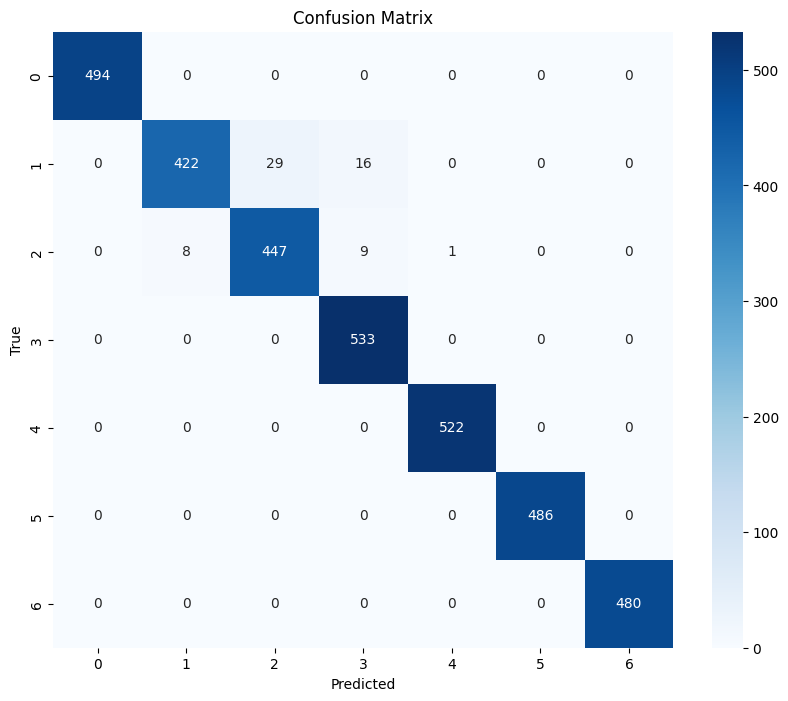

In [41]:
# 검증 데이터로 예측
def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return all_preds, all_labels

val_preds, val_labels = evaluate_model(model, val_loader)

# 정확도 계산
accuracy = sum(np.array(val_preds) == np.array(val_labels)) / len(val_labels)
print(f'Validation Accuracy: {accuracy:.4f}')

# 혼동 행렬
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [42]:
# 모델 저장
torch.save(model.state_dict(), 'wrinkle_classifier_resnet50.pth')

# 모델 로드 (예시)
# loaded_model = models.resnet50()
# loaded_model.fc = nn.Linear(loaded_model.fc.in_features, 10)
# loaded_model.load_state_dict(torch.load('wrinkle_classifier_resnet50.pth'))
# loaded_model = loaded_model.to(device)

### ResNet 주름 “분류” 모델 로드 & 평가 (2026년 2월 10일 시점)
#### 0) 설정: 경로/기본 import

In [2]:
import os, json
from PIL import Image
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models

from sklearn.metrics import classification_report, confusion_matrix

ROOT_DIR = r"D:\PyProject\datasets\skinAI\korea_skin_data\model_and_data\docker_image\skin_dataset\data_and_model\dataset"
CKPT_PATH = r"wrinkle_classifier_resnet50.pth"  # 저장한 모델 파일 경로 (현재 작업폴더에 있으면 그대로)
ANGLE_LIST = ["F", "L", "R"]
LABEL_SUFFIX = "_01"  # 주름 라벨 파일이 *_01.json 이라고 하셨음

D:\anaconda3\envs\skin_ai\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
## 1) 평가용 Transform (증강 X)
val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

## 2) WrinkleDataset “재작성”(평가용, 단순/안전)
class WrinkleDataset(Dataset):
    """
    label: label/03/{id}/{id}_03_{angle}_01.json
    image: img/03/{id}/{id}_03_{angle}.jpg
    target: annotations['forehead_wrinkle'] (0~6)
    """
    def __init__(self, root_dir, transform=None, angles=("F","L","R")):
        self.root_dir = root_dir
        self.transform = transform
        self.angles = angles
        self.samples = self._collect_samples()

    def _collect_samples(self):
        samples = []
        label_root = os.path.join(self.root_dir, "label", "03")
        img_root   = os.path.join(self.root_dir, "img", "03")

        # 0001 ~ 1100 가정 (사용자님 코드 기준)
        for folder_num in range(1, 1101):
            fid = f"{folder_num:04d}"
            for angle in self.angles:
                img_path   = os.path.join(img_root, fid, f"{fid}_03_{angle}.jpg")
                label_path = os.path.join(label_root, fid, f"{fid}_03_{angle}{LABEL_SUFFIX}.json")

                if not (os.path.exists(img_path) and os.path.exists(label_path)):
                    continue

                try:
                    with open(label_path, "r", encoding="utf-8") as f:
                        data = json.load(f)
                    y = int(data["annotations"]["forehead_wrinkle"])
                    if 0 <= y <= 6:
                        samples.append((img_path, y))
                except Exception:
                    # 깨진 json/키 오류 등은 스킵
                    continue

        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, y = self.samples[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(y, dtype=torch.long)

In [6]:
## 3) Dataset 만들고 Train/Val/Test로 분리 (1년 전 재현용)
full_dataset = WrinkleDataset(root_dir=ROOT_DIR, transform=val_transform, angles=ANGLE_LIST)
print("Total samples:", len(full_dataset))

# 재현성 고정
g = torch.Generator().manual_seed(42)

n = len(full_dataset)
train_n = int(n * 0.8)
val_n   = int(n * 0.1)
test_n  = n - train_n - val_n

train_ds, val_ds, test_ds = random_split(full_dataset, [train_n, val_n, test_n], generator=g)

# 평가할 때는 val_ds 또는 test_ds 사용
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=0)

Total samples: 3216


In [8]:
## 4) 저장된 ResNet50 모델 로드
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

model = models.resnet50(weights=None)     # 평가만 할 거라 weights=None 권장(불필요 다운로드 방지)
model.fc = nn.Linear(model.fc.in_features, 7)

state = torch.load(CKPT_PATH, map_location=device)
model.load_state_dict(state)
model.to(device)
model.eval()

device: cuda


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [12]:
# 5) Test 성능 평가(Accuracy + Report + Confusion Matrix)
def eval_classification(model, loader):
    preds, trues = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            out = model(x)
            pred = out.argmax(dim=1)
            preds.extend(pred.cpu().numpy())
            trues.extend(y.cpu().numpy())
    preds = np.array(preds)
    trues = np.array(trues)
    acc = (preds == trues).mean()
    return acc, preds, trues

acc, preds, trues = eval_classification(model, test_loader)
# print("TEST ACC:", acc)
print(f"test 정확도 {acc * 100:.2f}%")

print("\nClassification report:")
print(classification_report(trues, preds, digits=4))

print("\nConfusion matrix:")
print(confusion_matrix(trues, preds))

test 정확도 97.83%

Classification report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        10
           1     1.0000    0.9573    0.9782       117
           2     0.9405    0.9753    0.9576        81
           3     0.9818    1.0000    0.9908        54
           4     0.9524    1.0000    0.9756        20
           5     1.0000    1.0000    1.0000        18
           6     1.0000    1.0000    1.0000        23

    accuracy                         0.9783       323
   macro avg     0.9821    0.9904    0.9860       323
weighted avg     0.9791    0.9783    0.9784       323


Confusion matrix:
[[ 10   0   0   0   0   0   0]
 [  0 112   5   0   0   0   0]
 [  0   0  79   1   1   0   0]
 [  0   0   0  54   0   0   0]
 [  0   0   0   0  20   0   0]
 [  0   0   0   0   0  18   0]
 [  0   0   0   0   0   0  23]]
